Cначала я юзал только xgb, довел до хорошего результата на паблике 0.7724

Под конец соревнования узнал о lightgbm, и просто сблендил lightgbm и xgb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [3]:
train = pd.read_pickle('data/train_prep.pkl')
test = pd.read_pickle('data/test_prep.pkl')

In [4]:
outcome = pd.read_csv('data/credit_train.csv',sep = ';')
y = outcome['open_account_flg']

In [5]:
del train['client_id']
del test['client_id']

C:\ProgramData\Anaconda2\lib\site-packages\pandas\indexes\base.py:2134: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.get_loc(key)


In [7]:
lgb_train = lgb.Dataset(train.values,label=y)

In [9]:
scale_pos_weight = np.sum(y == 0) / float(np.sum(y == 1))
print scale_pos_weight

4.68092893266


10517
0.771307461619
Wall time: 10h 11min


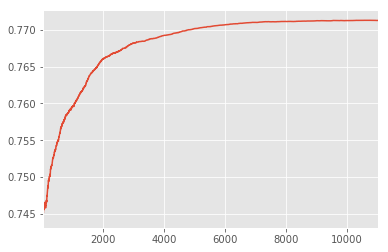

In [57]:
%%time

params = {
    'objective': 'binary',
    'metric':  'auc',
    'boosting':'dart',
    'num_leaves':31,
    'learning_rate': 0.01,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'scale_pos_weight':scale_pos_weight
}
cv = lgb.cv(params, lgb_train, 11000, nfold=4, early_stopping_rounds=500)
print pd.Series(cv['auc-mean']).argmax()
print pd.Series(cv['auc-mean'])[pd.Series(cv['auc-mean']).argmax()]
pd.Series(cv['auc-mean'])[40:].plot()

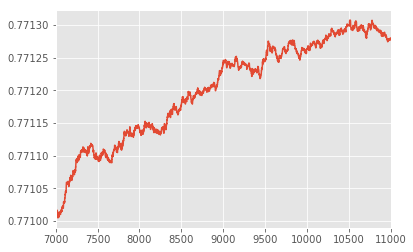

In [61]:
pd.Series(cv['auc-mean'])[7000:].plot()

In [58]:
ll = lgb.train(params, lgb_train, num_boost_round=pd.Series(cv['auc-mean']).argmax())

In [62]:
ll.save_model('microsoft_best.model')

In [77]:
pred = ll.predict(test.values)

In [81]:
best = pd.read_csv('xgb_best.csv',sep = ',')

In [83]:
best['new'] = pred

In [100]:
best['sred'] = (0.5 * best['new'] +  0.5 * best['p'] )

In [102]:
ans = pd.DataFrame()
tt = pd.read_csv('data/credit_test.csv',sep = ';')
ans['id'] = tt['client_id']
ans['p'] = best['sred']
ans.to_csv('xgb_and_ll.csv',index=False, sep = ',')